In [37]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
from ipyleaflet import Map, Marker
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother, DecomposeSmoother
from tsmoothie.bootstrap import BootstrappingWrapper
import xarray as xr

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('d2de6b1461274bc0b832979219b018a9')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [4]:
#py kernel must be in same location as data directory
crop_presence_data = pd.read_csv("./Data/Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [5]:
def create_bbox(lat_long, size_px):
    
    box_size_deg = 0.00008 * size_px 

    min_lon = lat_long[1]-box_size_deg/2
    min_lat = lat_long[0]-box_size_deg/2
    max_lon = lat_long[1]+box_size_deg/2
    max_lat = lat_long[0]+box_size_deg/2

    bbox = (min_lon, min_lat, max_lon, max_lat)
    return bbox

def smooth_data(data, window_size=3):
    data = data.rolling(window_size, center=True).mean()
    return data

def db_scale(x):
    return 10 * np.log10(x)

In [6]:
def get_sentinel_data(latlong, time_slice,assets, bbox_size_px = 5):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''
    
    scale = 100 / 111320.0

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox = create_bbox([float(latlong[0]),float(latlong[1])], bbox_size_px)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assets
    data = stac_load(items, bands = bands_of_interest, patch_url=pc.sign, bbox=bbox, crs="EPSG:4326", resolution=scale) 
    return data

In [47]:
time_slice = "2021-12-01/2022-04-30"
assets = ['vh','vv']
vh_vv = []
coordinates=crop_presence_data['Latitude and Longitude']
data = db_scale(get_sentinel_data(coordinates[0],time_slice,assets, bbox_size_px = 5))
data.head()
mean = data.mean(dim=['latitude','longitude']).compute()
crossCo = (mean.vv/mean.vh)
mean = mean.to_array(dim='time')
xr.concat([mean, crossCo], dim='time')

TypeError: Index.name must be a hashable type

In [25]:
#apply time series smoothing
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smoother.smooth(mean.to_array(dim='time'))
low, up = smoother.get_intervals('prediction_interval')
# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))

<Figure size 1800x500 with 0 Axes>

<Figure size 1800x500 with 0 Axes>

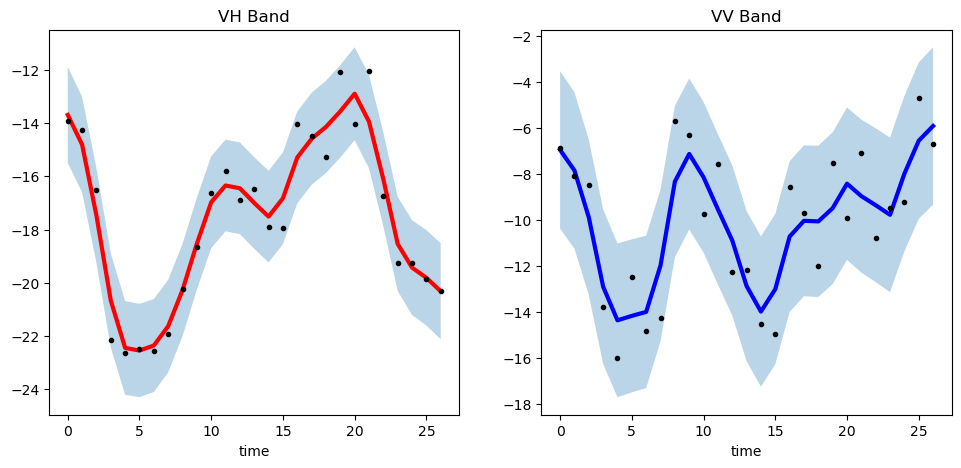

In [26]:
# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(smoother.smooth_data[0], linewidth=3, color='red')
plt.plot(smoother.data[0], '.k')
plt.title(f"VH Band"); plt.xlabel('time')

plt.fill_between(range(len(smoother.data[i])), low[0], up[0], alpha=0.3)

#plot for vv band
plt.subplot(1,3,2)
plt.plot(smoother.smooth_data[1], linewidth=3, color='blue')
plt.plot(smoother.data[1], '.k')
plt.title(f"VV Band"); plt.xlabel('time')

plt.fill_between(range(len(smoother.data[1])), low[1], up[1], alpha=0.3)

In [33]:
#try seasonal smoothing
# operate smoothing
smoother = DecomposeSmoother(smooth_type='lowess', periods=12,
                             smooth_fraction=0.3)
smoother.smooth(mean.to_array(dim='time'))

<tsmoothie.smoother.DecomposeSmoother>

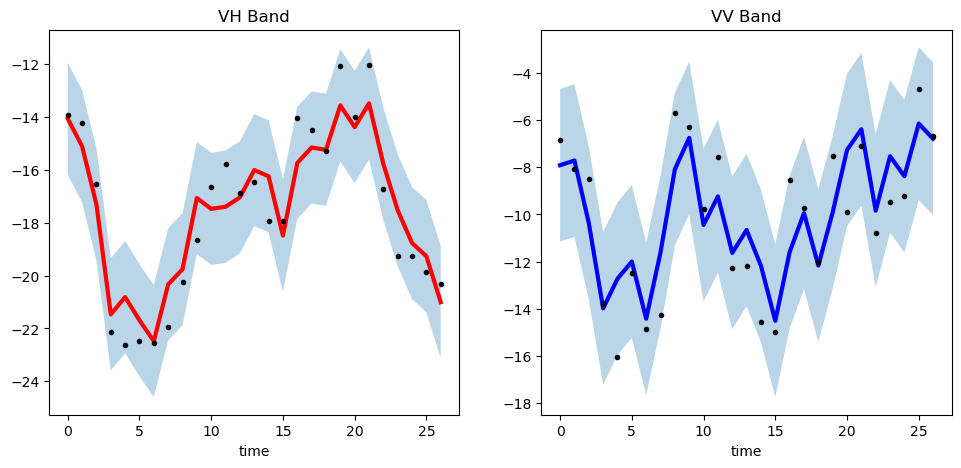

In [34]:
# generate intervals
low, up = smoother.get_intervals('sigma_interval')

# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(smoother.smooth_data[0], linewidth=3, color='red')
plt.plot(smoother.data[0], '.k')
plt.title(f"VH Band"); plt.xlabel('time')

plt.fill_between(range(len(smoother.data[i])), low[0], up[0], alpha=0.3)

#plot for vv band
plt.subplot(1,3,2)
plt.plot(smoother.smooth_data[1], linewidth=3, color='blue')
plt.plot(smoother.data[1], '.k')
plt.title(f"VV Band"); plt.xlabel('time')

plt.fill_between(range(len(smoother.data[1])), low[1], up[1], alpha=0.3)

C-band:
Dual polarisation C-band is perhaps perfectly apt for irrigated rice monitoring, where the VV and
VH backscatter are dominated by specular double-bounce and volume scattering, respectively.
The shorter C-band signal displays stronger sensitivity than L-band also to the early growth stages
when the young rice plans are too small to be detected at L-band. This is illustrated in the bottom
figure above, where the wide range of different colours in the C-band RGB image represent
growth stage variations between the fields.

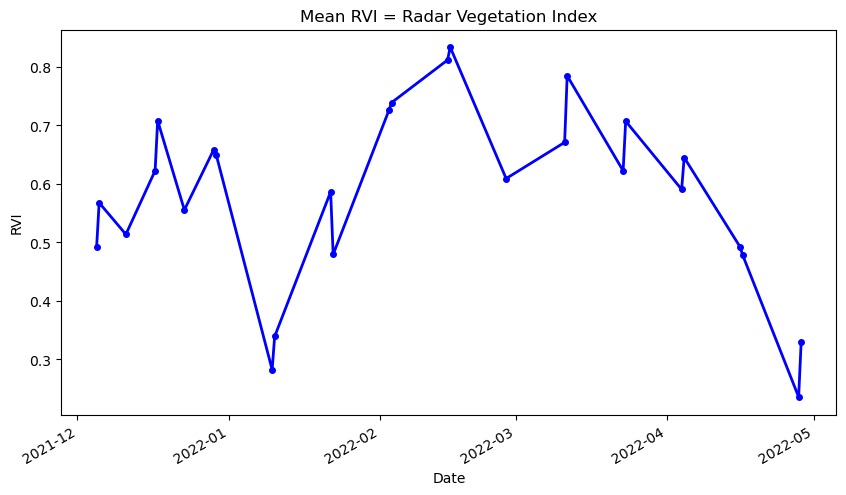

In [14]:
fig = plt.figure(figsize=(10, 5))
crossCo.plot(color='blue',marker='o',markersize=4,linewidth=2)


plt.title("Mean RVI = Radar Vegetation Index")
plt.xlabel("Date")
plt.ylabel("RVI")
plt.show()

In [19]:
time_slice = "2021-12-01/2022-04-30"
assets = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assets))
vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 600/600 [02:14<00:00,  4.47it/s]


In [60]:
def combine_two_datasets(dataset1,dataset2):
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [63]:
crop_data = combine_two_datasets(crop_presence_data,rvi)
crop_data.head()
#save the data using pickle
#crop_data.to_pickle("./Data/crop_data.pkl")

TypeError: cannot concatenate object of type '<class 'xarray.core.dataarray.DataArray'>'; only Series and DataFrame objs are valid